In [14]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [15]:
from astropy.io import fits
from astropy import wcs
fits_image_filename = '../Data/newfits/calexp-1-108438.fits'

hdu_list = fits.open(fits_image_filename)
hdu = fits.open(fits_image_filename)[1]
w = wcs.WCS(hdu.header)

In [16]:
image_data = fits.getdata(fits_image_filename,0)
print(type(image_data))
print(image_data.shape)
# Parse the WCS keywords in the primary HDU
print(w)

<class 'numpy.ndarray'>
(6132, 8176)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 151.891410835415  41.777202445749  
CRPIX : 4074.320544  3065.826822  
CD1_1 CD1_2  : -9.05112531824021e-07  -0.000347023189685797  
CD2_1 CD2_2  : 0.000346982413101619  -9.20137431574141e-07  
NAXIS : 8176  6132


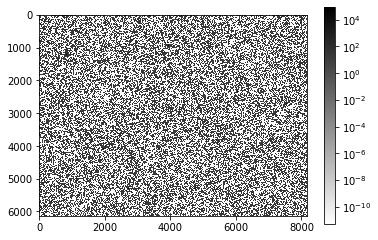

In [17]:
plt.imshow(image_data,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [18]:
from astropy.convolution import Gaussian2DKernel
from photutils import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources
data = image_data
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)

In [19]:
from astropy.stats import gaussian_fwhm_to_sigma
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
#segm_deblend = deblend_sources(data, segm, npixels=npixels,filter_kernel=kernel, nlevels=32,contrast=0.001)

In [47]:
from photutils import source_properties
cat = source_properties(data, segm, wcs=w)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'
tbl['ycentroid'].info.format = '.2f'
tbl['ellipticity'].info.format = '.2f'
tbl['equivalent_radius'].info.format = '.2f'
print(tbl)

 id  xcentroid ycentroid ...         cyy                 gini       
        pix       pix    ...       1 / pix2                         
---- --------- --------- ... ------------------- -------------------
   1   2317.21      3.39 ...  0.5071554388849319  0.5974476954066643
   2   3310.82      1.22 ...  1.2272596755376408   0.262394909072094
   3   5764.48      4.72 ... 0.28960390269769576  0.7230735354310308
   4   6920.70      1.37 ...  0.5464463979263567  0.7573192720452272
   5   1530.08      5.13 ...  0.8492711332212144  0.3007938618148653
   6   4639.78      5.63 ...  0.8229403740037532 0.24297215256697732
   7   1828.32      9.45 ... 0.46902675720145465  0.6232578842343054
   8   3385.72      9.48 ...  0.4893899648297847  0.5378952722180029
   9    993.96     12.36 ...  0.5183897598178111  0.5176076963128391
  10   2506.35     13.55 ...    1.67966218275459 0.14751848745902124
 ...       ...       ... ...                 ...                 ...
2941   7425.99   6115.51 ... 0.451

In [48]:
dataframe = tbl.to_pandas()

In [50]:
df = dataframe

## Cutouts

In [51]:
indexNames = df[df['xcentroid'] < 400].index
print(indexNames)

Int64Index([  60,   61,   84,   86,   96,   99,  142,  190,  217,  229,
            ...
            2785, 2789, 2834, 2837, 2865, 2872, 2873, 2905, 2931, 2938],
           dtype='int64', length=135)


In [52]:
indexNames = df[df['xcentroid'] < 400].index
dfsel = df.drop(indexNames)
indexNames = dfsel[dfsel['xcentroid'] > 7776].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['ycentroid'] < 300].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['ycentroid'] > 5832].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['elongation'] > 10].index
dfsel = dfsel.drop(indexNames)
print(dfsel)

        id    xcentroid    ycentroid  sky_centroid.ra  sky_centroid.dec  \
117    118  1751.308771   302.236109       153.158214         40.970579   
118    119  6276.520949   309.069830       153.181520         42.533604   
119    120  3010.498063   311.189794       153.162926         41.404998   
120    121   989.355775   314.224136       153.146903         40.708890   
121    122  3169.523926   323.080086       153.158494         41.460012   
...    ...          ...          ...              ...               ...   
2755  2756  1463.793207  5826.794206       150.633059         40.866663   
2756  2757  1596.409726  5828.523477       150.630972         40.912242   
2757  2758  2545.994328  5827.253490       150.622545         41.239467   
2758  2759  5713.886492  5831.000413       150.595120         42.334878   
2760  2761  2262.001952  5830.381343       150.623752         41.141460   

      sky_centroid_icrs.ra  sky_centroid_icrs.dec     source_sum  \
117             153.158214     

In [61]:
dfsel.reset_index()
print(dfsel['sky_centroid.ra'])

117     153.158214
118     153.181520
119     153.162926
120     153.146903
121     153.158494
           ...    
2755    150.633059
2756    150.630972
2757    150.622545
2758    150.595120
2760    150.623752
Name: sky_centroid.ra, Length: 2386, dtype: float64


In [63]:
dfsel = dfsel[['xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','elongation','equivalent_radius','area']]

In [66]:
coords = list(zip(dfsel.xcentroid, dfsel.ycentroid))
print(coords)

[(1751.3087707300392, 302.23610873653615), (6276.520948560798, 309.06982992010893), (3010.498063471877, 311.1897942077577), (989.3557754598116, 314.224136474167), (3169.5239258089796, 323.0800858671331), (5755.396830748483, 321.13182737693865), (7483.153883766415, 331.16013551271305), (2914.7553524374175, 333.9852602108037), (5920.2296063463555, 348.3383226063963), (417.86287436428705, 349.41208325485024), (2990.312242090784, 350.3370013755158), (2285.6273344651954, 360.1281833616299), (3855.6561570596023, 366.5308067871203), (7660.924695134728, 368.5958596991158), (956.0865234982882, 366.8502956738251), (2908.9823549372245, 366.99864268747876), (3026.401148390002, 370.3285014636343), (6390.762809187279, 370.879785041225), (4748.976712140003, 376.38941711451014), (5157.875801472334, 376.6652814058418), (7472.313293970299, 380.9794238683128), (960.8990505359877, 381.72551301684535), (7344.146007789679, 383.24333008763386), (1139.1108916478556, 382.61258465011286), (3089.5608416725854, 4

In [68]:
dfsel['coords'] = coords

/Users/Kevin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
print(dfsel)

        xcentroid    ycentroid  sky_centroid.ra  sky_centroid.dec  elongation  \
117   1751.308771   302.236109       153.158214         40.970579    1.355859   
118   6276.520949   309.069830       153.181520         42.533604    2.096680   
119   3010.498063   311.189794       153.162926         41.404998    1.588629   
120    989.355775   314.224136       153.146903         40.708890    1.117614   
121   3169.523926   323.080086       153.158494         41.460012    1.529592   
...           ...          ...              ...               ...         ...   
2755  1463.793207  5826.794206       150.633059         40.866663    1.375169   
2756  1596.409726  5828.523477       150.630972         40.912242    1.314637   
2757  2545.994328  5827.253490       150.622545         41.239467    1.750463   
2758  5713.886492  5831.000413       150.595120         42.334878    1.335369   
2760  2262.001952  5830.381343       150.623752         41.141460    7.932118   

      equivalent_radius   a

In [26]:
from astropy import units as u
from astropy.nddata import Cutout2D
size = u.Quantity([40, 40], u.pixel)
cutout = []
cutout1 = Cutout2D(data=image_data,position=coords[1],size=40)
#for i in coords:
    #cutout.append(Cutout2D(data = image_data,position = coords[i],size = size))
#print(cutout)
print(cutout1)


In [27]:
print(hdu.data)

[[-1.90063822e+01 -1.90063822e+01  7.60255289e+00 ...  4.56153173e+01
   1.52051058e+01  4.56153173e+01]
 [-5.70191467e+01 -8.36280818e+01  6.08204231e+01 ...  4.99866815e-12
  -1.33044676e+02  7.98268054e+01]
 [ 3.42114880e+01 -3.42114880e+01  4.99866815e-12 ... -5.70191467e+01
  -4.94165938e+01 -3.42114880e+01]
 ...
 [-1.52051058e+01 -1.52051058e+01 -3.80127645e+00 ... -6.08204231e+01
  -1.14038293e+02  5.32178702e+01]
 [-2.66089351e+01  7.98268054e+01  2.66089351e+01 ...  3.80127645e+00
  -4.18140409e+01 -1.90063822e+01]
 [-1.52051058e+01 -5.32178702e+01 -1.14038293e+01 ...  3.80127645e+01
  -7.60255289e+00  3.42114880e+01]]


In [28]:
# Make the cutout, including the WCS
cutout = Cutout2D(image_data, position=coords[1000], size=size, wcs=w)

# Put the cutout image in the FITS HDU
hdu.data = cutout.data

# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header())

# Write the cutout to a new FITS file
cutout_filename = '001.fits'
hdu.writeto(cutout_filename, overwrite=True)

In [29]:
# Make the cutout, including the WCS
cutout = Cutout2D(image_data, position=coords[1000], size=size, wcs=w)

# Put the cutout image in the FITS HDU
hdu = fits.PrimaryHDU(cutout.data)

# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header(relax=False))


# Write the cutout to a new FITS file
cutout_filename = '004.fits'
hdu.writeto(cutout_filename, overwrite=True)

In [30]:
print(cutout.wcs.to_header(relax=False))

WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =         -2316.679456 / Pixel coordinate of reference point            CRPIX2  =           229.826822 / Pixel coordinate of reference point            PC1_1   = -9.0511253182402E-07 / Coordinate transformation matrix element       PC1_2   =  -0.0003470231896858 / Coordinate transformation matrix element       PC2_1   =  0.00034698241310162 / Coordinate transformation matrix element       PC2_2   = -9.2013743157414E-07 / Coordinate transformation matrix element       CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---TAN'           / TAN (gnomonic) projection + SIP distortions    CTYPE2  = 'DEC--TAN'           / TAN (gn

In [31]:
cutout.data

array([[-1.14038293e+01,  7.98268054e+01, -3.42114880e+01, ...,
        -3.80127645e+01, -7.60255289e+00, -3.42114880e+01],
       [ 5.32178702e+01,  3.04102116e+01,  2.66089351e+01, ...,
         1.14038293e+01,  6.46216996e+01, -2.28076587e+01],
       [ 4.18140409e+01,  5.70191467e+01,  9.12306347e+01, ...,
        -4.94165938e+01, -7.60255289e+00, -7.22242525e+01],
       ...,
       [ 2.66089351e+01,  3.80127645e+01, -3.80127645e+01, ...,
         3.04102116e+01,  7.60255289e+00,  3.80127645e+00],
       [ 1.90063822e+01, -4.18140409e+01, -9.12306347e+01, ...,
        -5.70191467e+01, -1.52051058e+01, -7.60255289e+00],
       [-3.80127645e+00,  2.28076587e+01, -1.14038293e+01, ...,
         4.99866815e-12,  3.80127645e+01,  4.56153173e+01]])

In [32]:
fits_image_filename = '004.fits'

hdu_list_cutout = fits.open(fits_image_filename)

image_data_cutout = fits.getdata(fits_image_filename,0)
print(type(image_data_cutout))
print(image_data_cutout.shape)

<class 'numpy.ndarray'>
(40, 40)


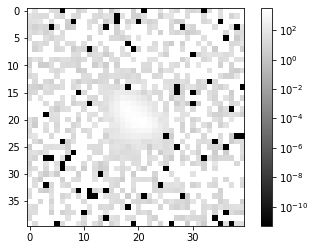

In [33]:
plt.imshow(image_data_cutout,cmap='gray',norm=LogNorm())
plt.colorbar()

In [34]:
print(coords[1000])

(6410.33456239084, 2855.4925286241023)


In [35]:
hdu_list_cutout.info()

Filename: 004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (40, 40)   float64   


In [36]:
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(hdu_list_cutout[1].header)
print(w)

IndexError: list index out of range

In [ ]:
hdu_list_cutout_sky = w.all_pix2world(hdu_list_cutout[1],0)

## Demo

In [ ]:
plt.imshow(image_data,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x="elongation", y="equivalent radius")
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.show()

In [ ]:
print(df[df['equivalent radius'] > 20])

In [ ]:
print(df[(df['elongation'] > 3) & (df['equivalent radius'] > 4)])

In [ ]:
print(df[(df['xcentroid'] > 1480) & (df['xcentroid'] < 1490)])

In [ ]:
X = df[['elongation','equivalent radius']]
from sklearn import preprocessing                      #Feature scaling
scaler = preprocessing.RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=list(X.columns.values))
X = X_scaled
print(X_scaled.shape)  

## Clustering

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
Knumber=[]
CHnumber=[]
for i in range(2,9):
    Knumber.append(i)
    y_pred = KMeans(n_clusters=i).fit_predict(X)
    CHnumber.append(metrics.calinski_harabasz_score(X,y_pred))
plt.plot(Knumber,CHnumber,marker='o',ls='--')
plt.title('Looking for The Best K')
plt.xlabel('K')
plt.ylabel('Calinski-Harabasz Index')

In [ ]:
for i in [2,3]:
    kmeans = KMeans(n_clusters=i).fit(X)
    centroids = kmeans.cluster_centers_
    print('centers are:',centroids)

    fig= plt.figure(figsize=(20,10))
    x =X['equivalent radius']
    y =X['elongation']

    plt.scatter(x, y, c= kmeans.labels_.astype(float),s=5, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, alpha=1)
    plt.xlabel('equivalent radius')
    plt.ylabel('elongation')
    plt.title('K means clustering')

    plt.show()

## Sanity Check

In [ ]:
data = image_data[:500,:500]
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
cat = source_properties(data, segm)
r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 125))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=LogNorm())
ax1.set_title('Data')
cmap = segm.make_cmap(random_state=12345)
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)